<a href="https://colab.research.google.com/github/prakhartiwari10/Pytorch-projects/blob/main/Cifar10_CNN_Pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [20]:
import os
import torch
from torch import nn
import torchvision
import tarfile
from torchvision.datasets.utils import download_url
from torch.utils.data import random_split

In [21]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [22]:
dataset_url = "https://s3.amazonaws.com/fast-ai-imageclas/cifar10.tgz"
download_url(dataset_url, '.')

Using downloaded and verified file: ./cifar10.tgz


In [23]:
with tarfile.open('./cifar10.tgz', 'r:gz') as tar:
  tar.extractall(path = './data')

In [24]:
data_dir = './data/cifar10'
print(os.listdir(data_dir))
classes = os.listdir(data_dir + "/train")
print(classes)

['test', 'train']
['horse', 'cat', 'truck', 'bird', 'ship', 'airplane', 'frog', 'dog', 'automobile', 'deer']


In [25]:
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor

In [26]:
dataset = ImageFolder(data_dir + '/train', transform=ToTensor())

In [27]:
img, label = dataset[1]
print(img.shape, label)

torch.Size([3, 32, 32]) 0


In [28]:
print(dataset.classes)

['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


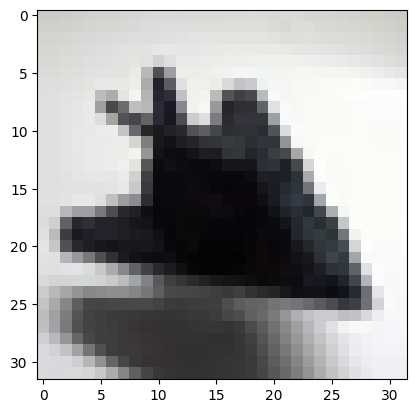

In [29]:
import matplotlib.pyplot as plt
img, label = dataset[0]
plt.imshow(img.permute(1,2,0))

In [30]:
data_loader = torch.utils.data.DataLoader(dataset, batch_size=16, shuffle=True)
sample_batch = next(iter(data_loader))

In [31]:
def show_batch(sample):
  img_batch, label_batch = sample
  batch_size = len(sample)

  grid = torchvision.utils.make_grid(img_batch, nrow=4)
  plt.figure(figsize=(10,10))
  plt.imshow(grid.permute(1,2,0))

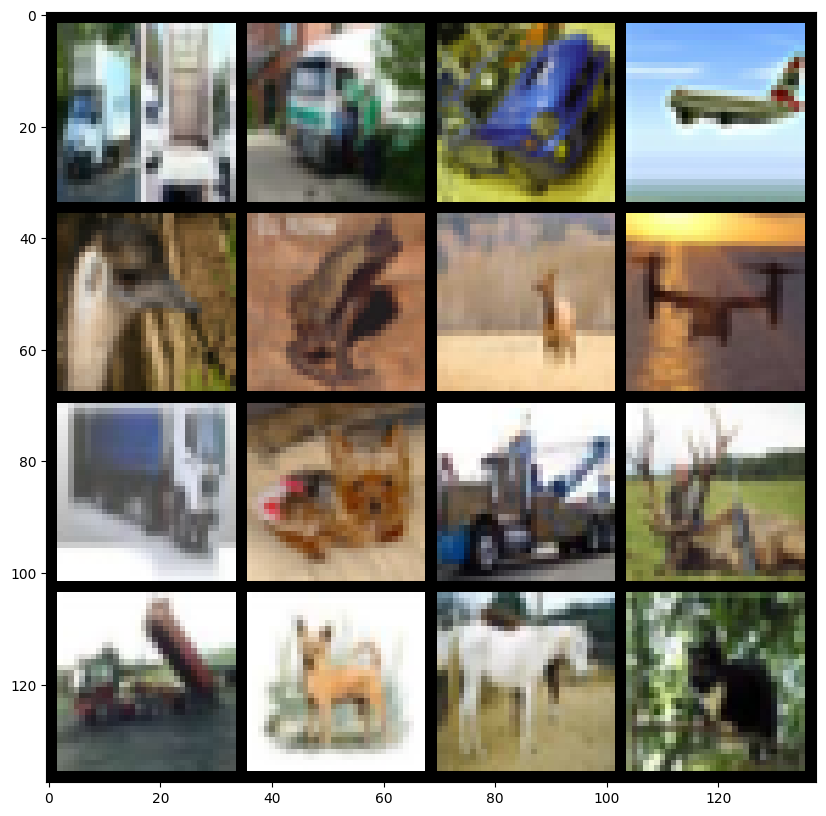

In [32]:
show_batch(sample_batch)

In [33]:
train_size = int(0.8*len(dataset))
test_size = len(dataset)-train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])
len(train_dataset), len(test_dataset)

(40000, 10000)

In [34]:
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=True)

In [35]:
class CifarModel(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )

        # Define the fully connected layers
    self.fc_layers = nn.Sequential(
        nn.Flatten(),
        nn.Linear(64 * 8 * 8, 256),
        nn.ReLU(),
        nn.Dropout(0.25),
        nn.Linear(256, 10)
    )

  def forward(self, x):
    x = self.conv_layers(x)
    x = self.fc_layers(x)
    return x

In [39]:
model = CifarModel().to(device)
model

CifarModel(
  (conv_layers): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc_layers): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=4096, out_features=256, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.25, inplace=False)
    (4): Linear(in_features=256, out_features=10, bias=True)
  )
)

In [40]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model.parameters(), lr=0.1)

In [42]:
# Training loop
epochs = 3
for epoch in range(epochs):
  train_loss = 0
  for batch, (X, y) in enumerate(train_dataloader):
    X = X.to(device)
    y = y.to(device)
    y_pred = model(X)
    loss = loss_fn(y_pred, y)
    train_loss += loss
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if batch%400 == 0:
      print(f"batch: {batch}")

  train_loss /= len(train_dataloader)

  test_loss = 0
  with torch.inference_mode():
    for X, y in test_dataloader:
      X, y = X.to(device), y.to(device)
      test_pred = model(X)
      test_loss += loss_fn(test_pred, y)

    test_loss /= len(test_dataloader)

  print(f"Epoch: {epoch}, train_loss: {train_loss}, test_loss: {test_loss}")

batch: 0
batch: 400
Epoch: 0, train_loss: 1.4767652750015259, test_loss: 1.3563646078109741
batch: 0
batch: 400
Epoch: 1, train_loss: 1.2688993215560913, test_loss: 1.17648184299469
batch: 0
batch: 400
Epoch: 2, train_loss: 1.1126048564910889, test_loss: 1.0947047472000122


In [43]:
def eval_model(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               device : torch.device = device):
    loss = 0
    model.eval()
    with torch.inference_mode():
        for X, y in data_loader:

            X, y = X.to(device), y.to(device)
            y_pred = model(X)
            loss += loss_fn(y_pred, y)

        loss /= len(data_loader)
    return {"model_name": model.__class__.__name__,
            "model_loss": loss.item()}

model_results = eval_model(model=model, data_loader=test_dataloader,
    loss_fn=loss_fn,
    device=device
)
model_results

{'model_name': 'CifarModel', 'model_loss': 1.0557016134262085}

In [44]:
from pathlib import Path

MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True,
                 exist_ok=True
)


MODEL_NAME = "Cifar_CNN_Classification.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# Save the model state dict
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model.state_dict(), # only saving the state_dict() only saves the learned parameters
           f=MODEL_SAVE_PATH)

Saving model to: models/Cifar_CNN_Classification.pth


In [45]:
loaded_model = CifarModel()
# Load in the saved state_dict()
loaded_model.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

# Send model to GPU
loaded_model_2 = loaded_model.to(device)

In [46]:
torch.manual_seed(42)

loaded_model_results = eval_model(
    model=loaded_model,
    data_loader=test_dataloader,
    loss_fn=loss_fn,
)

loaded_model_results

{'model_name': 'CifarModel', 'model_loss': 1.0577242374420166}